In [28]:
import pandas as pd


reviews_df = pd.read_csv("data_cleaned.csv")

reviews_df["is_bad_review"] = reviews_df["Rating"].apply(lambda x: 1 if x < 5 else 0)

reviews_df = reviews_df[["Verbatim Translated", "is_bad_review","Created"]]
reviews_df.head(2)

,Verbatim Translated,is_bad_review,Created
0,the hard -to -answer careline line needs to be...,0,8/27/2020 4:42:25 PM
1,there is no atm or rhb in jasin melaka,0,8/27/2020 5:22:49 PM


In [3]:
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)

In [30]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
import nltk
from nltk import pos_tag
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import datetime as dt
from sklearn import preprocessing

def clean_text(text):
    # lower text
    text = str(text).lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)
def normalize(df):
    x = df.values.reshape(-1,1) #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    result = pd.DataFrame(x_scaled)
    print(result)
    return result

def compute_time_score(x,recent_timestamp):
    epoch=x.timestamp()/(recent_timestamp.timestamp()+1)
    return epoch

# clean text data
reviews_df['Created'] = reviews_df['Created'].astype('datetime64[ns]')

recent_timestamp = reviews_df['Created'].max()
reviews_df["time_score"] = reviews_df["Created"].apply(lambda x: compute_time_score(x,recent_timestamp))
reviews_df["time_score"] = normalize(reviews_df["time_score"]).values
reviews_df["review_clean"] = reviews_df["Verbatim Translated"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


             0
0     0.331083
1     0.331123
2     0.331151
3     0.331292
4     0.331294
...        ...
3449  0.568494
3450  0.567764
3451  0.568726
3452  0.608991
3453  0.783161

[3454 rows x 1 columns]


In [26]:
reviews_df.head(2000)

,Verbatim Translated,is_bad_review,Created,time_score,review_clean
511,increase the promotion,1,2020-10-16 14:00:12,0.191911,increase promotion
51,special rate for special account,0,2020-08-27 16:51:27,0.095296,special rate special account
1171,maintain a good manner of service to customers,0,2021-02-21 18:16:24,0.440179,maintain good manner service customer
2282,personal loans for me to recommend to the whol...,0,2021-05-24 19:37:47,0.618483,personal loan recommend whole family friend
557,enable back ur security verification previousl...,1,2020-10-16 16:21:57,0.192102,enable back ur security verification previousl...
...,...,...,...,...,...
1748,call centre needs improvement takes around mi...,0,2021-04-26 21:49:37,0.564427,call centre need improvement take around min g...
1689,membership fees are very expensive I will stop...,0,2021-04-27 16:08:34,0.565905,membership fee expensive stop use rhb card
2221,faster service,0,2021-05-25 09:49:26,0.619628,faster service
2671,interest campaign or months attractive fd rate,0,2021-06-24 16:29:50,0.678274,interest campaign month attractive fd rate


In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["Verbatim Translated"].apply(lambda x: sid.polarity_scores(str(x)))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)


In [6]:
reviews_df["nb_chars"] = reviews_df["Verbatim Translated"].apply(lambda x: len(str(x)))

# add number of words column
reviews_df["nb_words"] = reviews_df["Verbatim Translated"].apply(lambda x: len(str(x).split(" ")))

In [7]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [9]:
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.881159
1    0.118841
Name: is_bad_review, dtype: float64

In [10]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# def show_wordcloud(data, title = None):
#     wordcloud = WordCloud(
#         background_color = 'white',
#         max_words = 200,
#         max_font_size = 40, 
#         scale = 3,
#         random_state = 42
#     ).generate(str(data))

#     fig = plt.figure(1, figsize = (20, 20))
#     plt.axis('off')
#     if title: 
#         fig.suptitle(title, fontsize = 20)
#         fig.subplots_adjust(top = 2.3)

#     plt.imshow(wordcloud)
#     plt.show()
    
# # print wordcloud
# show_wordcloud(reviews_df["review_clean"])

In [11]:
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["Verbatim Translated", "pos"]].head(10)


,Verbatim Translated,pos
2982,improve communication enhance platform proacti...,0.739
1459,easy to reach by phone interest free for easy ...,0.688
51,special rate for special account,0.643
3125,surprice or appreciation gift to customers,0.608
192,you the best already,0.583
2356,always have a reward event,0.552
134,take care of customers by giving lower interes...,0.544
2671,interest campaign or months attractive fd rate,0.541
3164,lower interest rate and better offer,0.532
17,improve the mobile app performance and security,0.515


In [12]:
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["Verbatim Translated", "neg"]].head(100)

,Verbatim Translated,neg
2274,stop spamming people phone with your advertise...,0.507
1510,please stop call spamming and unsolicited sale...,0.363
414,lower lg personal loan rate,0.355
1805,interest rate lower or slightly lower than oth...,0.328
610,call center never resolve my problem it take a...,0.328
...,...,...
678,make it more simpler,0.000
1592,improve on your calll centre service and respo...,0.000
527,upgrade rhb your credit card like maybank cred...,0.000
2707,reduce interest rates on loans,0.000


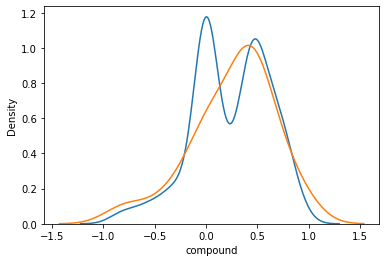

In [13]:
import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

In [16]:

# feature selection
label = "is_bad_review"
ignore_cols = [label, "Verbatim Translated", "review_clean","Created","time_score"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

In [17]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
10,doc2vec_vector_4,0.080000
4,nb_chars,0.064102
9,doc2vec_vector_3,0.063603
6,doc2vec_vector_0,0.062116
7,doc2vec_vector_1,0.059477
1,neu,0.050530
8,doc2vec_vector_2,0.049563
5,nb_words,0.048499
3,compound,0.044401
17,word_call,0.036035


In [ ]:
reviews_df.head()

,Verbatim Translated,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_rhb,word_service,word_staff,word_system,word_time,word_update,word_use,word_user,word_wait,word_well
511,increase the promotion,1,increase promotion,0.000,0.465,0.535,0.3182,22,3,0.031723,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,special rate for special account,0,special rate special account,0.000,0.357,0.643,0.6597,33,6,-0.069181,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1171,maintain a good manner of service to customers,0,maintain good manner service customer,0.000,0.674,0.326,0.4404,46,8,0.032102,...,0.000000,0.389871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2282,personal loans for me to recommend to the whol...,0,personal loan recommend whole family friend,0.000,0.641,0.359,0.6808,66,12,-0.029733,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
557,enable back ur security verification previousl...,1,enable back ur security verification previousl...,0.098,0.808,0.094,-0.0454,259,46,0.177944,...,0.810735,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


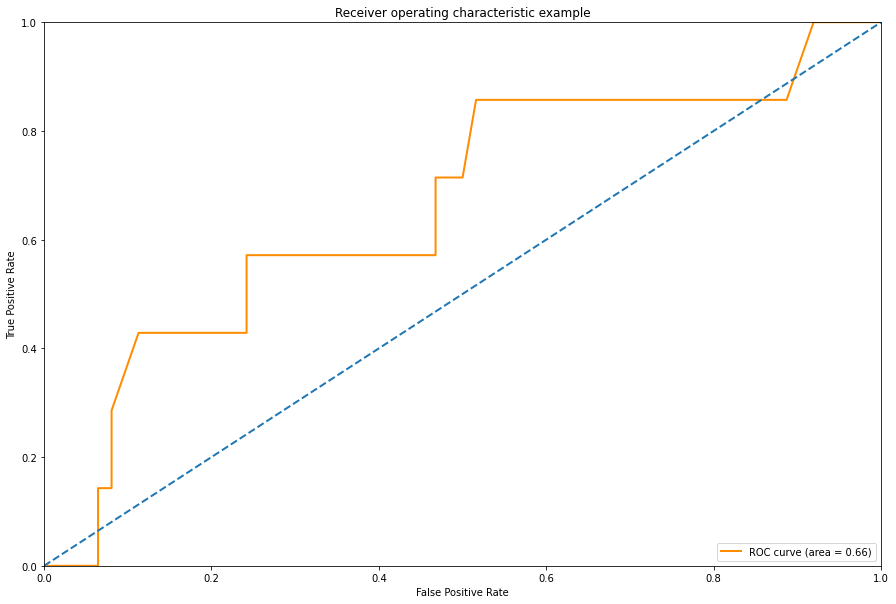

In [ ]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.20')

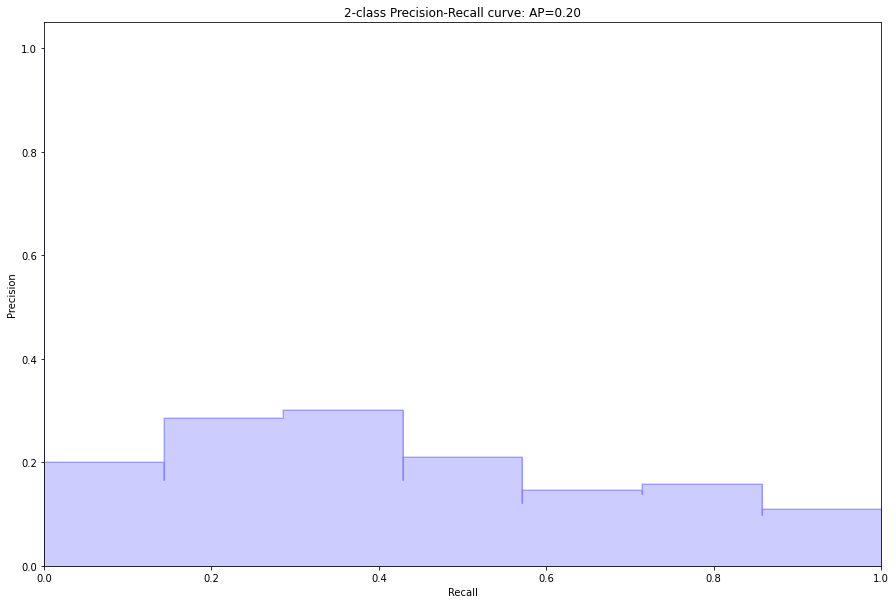

In [ ]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
from funcsigs import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))